# Finding answers to questions
A simple TTR-SPA model for QA from the paper "Finding answers to questions". 

## Extraction answer from question and memory 
The network implements the retrieval of fragment answers from a question's body and memory.

The memory consists of a set (vocabulary) of propositions. The body of the question is compared with the memory based on similarity and the most similar sentence is selected. Then the answer fragment is extracted from the most similar sentence. This is done by detaching the argument from the sentence that was asked for first (the question's lambdapath). 

The implementation is done by using the [Nengo Brain Maker](https://www.nengo.ai/). 

In [1]:
%matplotlib inline
import nengo
import nengo_spa as spa
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Change the seed of this RNG to change the vocabulary:
rng = np.random.RandomState(1)
# Number of dimensions of semantic pointers:
d = 128
# Group semantic pointers in a vocabulary called "vocab"
vocab = spa.Vocabulary(dimensions=d, pointer_gen=rng)
# Populate the vocabulary with simple and complex semantic pointers:
vocab.populate(
    """
    IND; LOC; TIME; 
    PRED; ARG1; ARG2; 
    BODY; LAMBDAPATH; LAMBDATYPE;
    CHASE; SEE; LIKE;
    DOG; CAT; COW; MOUSE;
    P1 = PRED * CHASE + ARG1 * DOG + ARG2 * CAT;
    P2 = PRED * CHASE + ARG1 * DOG + ARG2 * COW;
    P3 = PRED * SEE + ARG1 * DOG + ARG2 * MOUSE;
    P4 = PRED * SEE + ARG1 * MOUSE + ARG2 * COW;
    P5 = PRED * LIKE + ARG1 * CAT + ARG2 * MOUSE;
    P6 = PRED * LIKE + ARG1 * DOG + ARG2 * COW;
    FT = DOG * IND + CAT * IND + COW * IND + MOUSE * IND
    """
)
## The Px statements correspond to the following propositions: 
# P1 = dog chases cat
# P2 = dog chases cow
# P3 = dog sees mouse
# P4 = mouse sees cow
# P5 = cat likes mouse
# P6 = dog likes cow

# Add the identity vector to vocab as "I":
zero_vec = np.asarray([0] * (d-1))
one_vec = np.asarray([1])
my_vec = np.concatenate((one_vec, zero_vec))
vocab.add("I", my_vec)

# Some useful sub-vocabularies of semantic pointers are created to restrict probes:
# Long term memory is the subset of propositions from vocab.
# This corresponds to "M" from the paper. 
ltm = vocab.create_subset(["P1", "P2", "P3", "P4", "P5", "P6"])

# basic type vocab: 
basic_types = vocab.create_subset(["IND", "LOC", "TIME"])

# individuals vocab:
ind_types = vocab.create_subset(["DOG", "CAT", "COW", "MOUSE"])

# The inputs to the network are three questions, posed one after the other: 
# 1. Who does the cat like?
# 2. Who does the dog chase?
# 3. Who likes the cow?
def questions(t):
    if t < 0.25:
        return "LAMBDATYPE * IND + LAMBDAPATH * ARG2 + BODY * (PRED * LIKE + ARG1 * CAT * ARG2 * I)"
    elif t < 0.5:
        return "LAMBDATYPE * IND + LAMBDAPATH * ARG2 + BODY * (PRED * CHASE + ARG1 * DOG + ARG2 * I)"
    elif t < 0.75:
        return "LAMBDATYPE * IND + LAMBDAPATH * ARG1 + BODY * (PRED * LIKE + ARG1 * I + ARG2 * COW)"
    else:
        return "0"

# Note that the lamdba-abstracted argument position is filled with the identity vector "I".
# Answering:
# An answer for 1. can be found in P5 (i.e., MOUSE).
# 2. is ambiguous: possible answers are provided by P1 and P2 (i.e., CAT or COW).
# An answer for 3. can be found in P6 (i.e., DOG).

In [3]:
with spa.Network("QA") as model:
    question = spa.Transcode(questions, output_vocab=vocab)
    fragment_answer_with_mem = spa.State(vocab)
    fragment_answer = spa.State(vocab)
    # Winner-Takes-All autoassociatve memory
    model.assoc_mem = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=vocab,
        mapping=vocab.keys(),
        function=lambda x: x > 0.0
    )
    
    # A: Unbind body from question, substract lambdapath and send it to autoassociative memory:
    question * spa.sym("~BODY") - (question * spa.sym("~LAMBDAPATH")) >> model.assoc_mem
    # Unbind the fragment answer from memory, 
    # which is found as the value of LAMBDAPATH within questions:
    model.assoc_mem * ~(question * spa.sym("~LAMBDAPATH")) >> fragment_answer_with_mem
    
    # B: Without intermediate memory clean-up:
    (question * spa.sym("~BODY") - question * spa.sym("~LAMBDAPATH")) * ~(question * spa.sym("~LAMBDAPATH")) >> fragment_answer

In [4]:
with model:
    p_answer_with_mem = nengo.Probe(fragment_answer_with_mem.output, synapse=0.01)
    p_answer = nengo.Probe(fragment_answer.output, synapse=0.01)
    p_mem_in = nengo.Probe(model.assoc_mem.input, synapse=0.01)
    p_mem_out = nengo.Probe(model.assoc_mem.output, synapse=0.03)

In [6]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 't [s]')

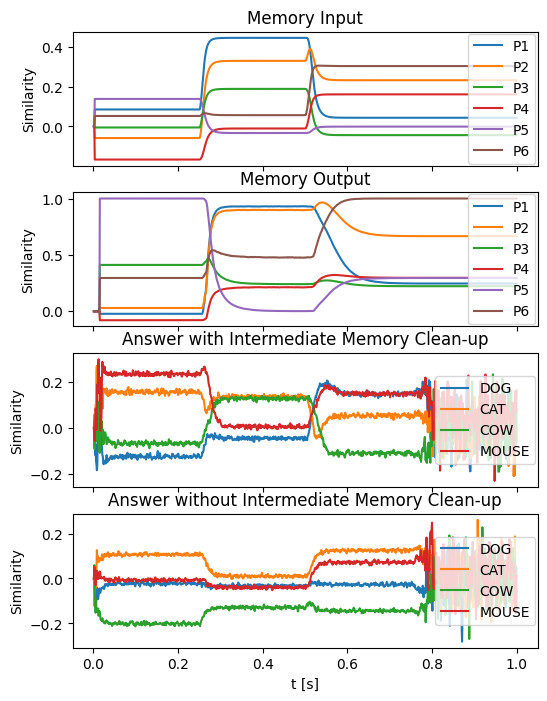

In [7]:
# Expectations:
# 1. source: P5; fragment: MOUSE
# 2. sources: P1 and P2; fragments: CAT or COW
# 3. source: P6; fragment: DOG

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(6, 8))

ax[0].plot(sim.trange(), spa.similarity(sim.data[p_mem_in], ltm, normalize=True))
ax[0].legend(list(ltm.keys()), bbox_to_anchor=(1.01,0.5), loc='right')
ax[0].set_ylabel("Similarity")
ax[0].set_title("Memory Input")

ax[1].plot(sim.trange(), spa.similarity(sim.data[p_mem_out], ltm, normalize=True))
ax[1].legend(list(ltm.keys()), bbox_to_anchor=(1.01,0.5), loc='right')
ax[1].set_ylabel("Similarity")
ax[1].set_title("Memory Output")

ax[2].plot(sim.trange(), spa.similarity(sim.data[p_answer_with_mem], ind_types, normalize=True))
ax[2].legend(list(ind_types.keys()), bbox_to_anchor=(1.01,0.5), loc='right')
ax[2].set_ylabel("Similarity")
ax[2].set_title("Answer with Intermediate Memory Clean-up")

ax[3].plot(sim.trange(), spa.similarity(sim.data[p_answer], ind_types, normalize=True))
ax[3].legend(list(ind_types.keys()), bbox_to_anchor=(1.01,0.5), loc='right')
ax[3].set_ylabel("Similarity")
ax[3].set_title("Answer without Intermediate Memory Clean-up")
ax[3].set_xlabel("t [s]")

## Type checking in vector space
Three functions -- CleanUp, TypeCheckingWithoutCleanup, and TypeCheckingWithCleanup -- are defined.
Type checking is spelled out as binding the retrieved basic type of the argument asked for with the inverse of the basic type found for the fragment answer in FT.
If both are equal, the result is expected to be approximately 1.
These functions are used to compare how well type checking works in vector space, with and without intermediate clean-up. 

In [8]:
def CleanUp(vector, vocab):
    """
    Returns the semantic pointer in the vocabulary that is most similar to the given vector.
    
    Args:
    - vector of a semantic pointer.
    - vocab (spa.Vocabulary): The vocabulary to look for the most similar semantic pointer.
    
    Returns:
    - str: The key of the semantic pointer in the vocab that is most similar to the input vector.
    """
    similarities = {key: np.dot(vector, vocab[key].v) for key in vocab.keys()}
    most_similar = max(similarities, key=similarities.get)
    
    return most_similar

In [9]:
def TypeCheckingWithoutCleanup(question, answer):
    """
    Returns the similarity of the result of binding 
    (i) the convolution of the inverse of the answer with FT, and
    (ii) the inverse of the result of unbing the LAMBDAPATH from the question.
    
    Args:
    - semantic pointer representing the question
    - semantic pointer representing the answer
    
    Returns: 
    Prints the similarity to the identity vector and the key of the most similar retrieved type 
    """
    convolve_type_involution = vocab.parse(f"(FT * ~{answer}) * ~({question} * ~LAMBDATYPE)").v
    type_check = np.dot(convolve_type_involution, vocab["I"].v)
    print(f"Without clean-up:\nSimilarity of type-checking to I is {type_check:.4f}")
    # What are the retrieved type?
    a_type_involution = vocab.parse(f"FT * ~{answer}").v
    q_type_involution = vocab.parse(f"{question} * ~LAMBDATYPE").v
    # clean-up in basic types:
    a_type = CleanUp(a_type_involution, basic_types)
    q_type = CleanUp(q_type_involution, basic_types)
    print(f"Cleaned-up retrieved basic types: question: {q_type}, answer: {a_type}")

In [10]:
def TypeCheckingWithCleanup(question, answer):
    """
    Returns the similarity of the result of binding 
    (i) the cleaned-up convolution of the inverse of the answer with FT, and
    (ii) the of the cleaned-up result of unbing the LAMBDAPATH from the question.
    
    Args:
    - semantic pointer representing the question
    - semantic pointer representing the answer
    
    Returns: 
    Prints the similarity to the identity vector and the key of the most similar retrieved type 
    """
    a_type_involution = vocab.parse(f"FT * ~{answer}").v
    q_type_involution = vocab.parse(f"{question} * ~LAMBDATYPE").v
    # clean-up in basic types:
    a_type = CleanUp(a_type_involution, basic_types)
    q_type = CleanUp(q_type_involution, basic_types)
    # convolve a_type with inverse of q_type:
    qa_type = vocab.parse(f"{a_type} * ~{q_type}").v
    type_check = np.dot(qa_type, vocab["I"].v)
    print(f"With clean-up:\nSimilarity of type-checking to I is {type_check:.4f}")
    # What is the retrieved type?
    print(f"Cleaned-up retrieved basic types: question: {q_type}, answer: {a_type}")

In [11]:
q = "LAMBDATYPE * IND + LAMBDAPATH * ARG2 + BODY * (PRED * CHASE + ARG1 * DOG + ARG2 * I)"
a = "CAT"

In [12]:
TypeCheckingWithoutCleanup(q,a)

Without clean-up:
Similarity of type-checking to I is 0.3909
Cleaned-up retrieved basic types: question: IND, answer: IND


In [13]:
TypeCheckingWithCleanup(q,a)

With clean-up:
Similarity of type-checking to I is 1.0000
Cleaned-up retrieved basic types: question: IND, answer: IND
